# Predicting Match Results in the Portuguese First League of Football

The goal of this project is to predict the results of football matches in the Portuguese first league. The objective is to model:

* Attacking strength
* Defensive strength
* Home advantage

for each team in the league. Various models should be tested, and relevant conclusions should be drawn.

# **Model I - Poisson Distribution**

This section is based on the following paper:  
* *Modelling Association Football Scores - M. J. Mahers*
* [http://www.90minut.pl/misc/maher.pdf](http://www.90minut.pl/misc/maher.pdf)  

In this section, we will explain how to build a model to predict football scores using the Poisson distribution. By the end, we will discover that the model is quite simplistic and has certain difficulties in some areas. However, the model provides a good starting point for our project.

## **Dataset**

Our model's operation is based on predicting the number of goals scored and conceded by each team when they play against each other, based on their historical performance. To achieve this, we will use a dataset of matches from the Portuguese First League of Football from the website [https://www.football-data.co.uk/portugalm.php](https://www.football-data.co.uk/portugalm.php), the dataset used refers to the 2021/22 championship.

In [ ]:
import pandas as pd

df = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/P1.csv")
df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,06/08/2021,Sp Lisbon,Vizela,3,0,H
1,07/08/2021,Arouca,Estoril,0,2,A
2,07/08/2021,Moreirense,Benfica,1,2,A
3,07/08/2021,Maritimo,Sp Braga,0,2,A
4,08/08/2021,Guimaraes,Portimonense,0,1,A
...,...,...,...,...,...,...
301,14/05/2022,Maritimo,Portimonense,0,1,A
302,14/05/2022,Porto,Estoril,2,0,H
303,14/05/2022,Sp Lisbon,Santa Clara,4,0,H
304,15/05/2022,Famalicao,Sp Braga,3,2,H


Currently, we have the team names (***HomeTeam*** and ***AwayTeam***), the number of goals scored by the home team at the end of the match (**FTHG**, *final time home goals*), the number of goals scored by the away team at the end of the match (**FTAG**, *final time away goals*), and who won (**FTR**, *final team result* where H is *HomeTeam* and A is *AwayTeam*).

## **Home Advantage I**

Let's begin by analyzing the basic information we have in our dataset. We'll start with the average number of goals scored.

In [ ]:
df[["FTHG", "FTAG"]].mean()

FTHG    1.431373
FTAG    1.205882
dtype: float64

In [ ]:
meanFTHG = df[["FTHG"]].mean()
meanFTAG = df[["FTAG"]].mean()
rel = float(meanFTHG)/float(meanFTAG)
print(rel)

1.1869918699186992


On average, the home team scores about `18.70%` more goals than the away team, so our model should take home advantage into consideration.  
Next, we'll plot the distribution of goals scored by the home and away teams.

Text(0.5, 1.0, 'Número de golos marcados por jogo')

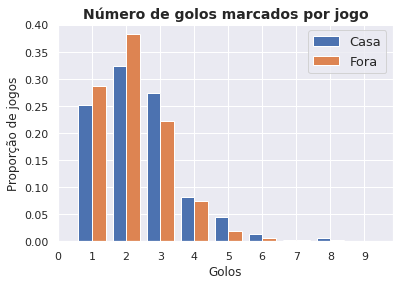

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
max_goals = 10
plt.hist(df[["FTHG", "FTAG"]].values, range(max_goals), label=["Casa", "Fora"], density=True)
plt.xticks([i - 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Golos")
plt.ylabel("Proporção de jogos")
plt.legend(loc="upper right", fontsize=13)
plt.title("Número de golos marcados por jogo", size=14, fontweight="bold")

The distribution appears quite similar to a *Poisson Distribution*. We can confirm our assumption by plotting the number of goals obtained from the *Poisson Distribution* along with the average number of goals we calculated above.

Text(0.5, 1.0, 'Número de golos marcados por jogo')

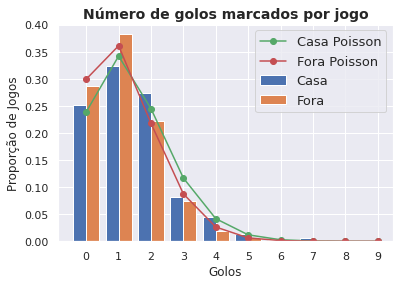

In [ ]:
import numpy as np
from scipy.stats import poisson

home_poisson = poisson.pmf(range(10), df["FTHG"].mean())
away_poisson = poisson.pmf(range(10), df["FTAG"].mean())

max_goals = 10
plt.hist(df[["FTHG", "FTAG"]].values, range(max_goals), label=["Casa", "Fora"], density=True)
plt.plot([i - 0.5 for i in range(1, max_goals + 1)], home_poisson, linestyle="-", marker="o", label="Casa Poisson",)
plt.plot([i - 0.5 for i in range(1, max_goals + 1)], away_poisson, linestyle="-", marker="o", label="Fora Poisson",)
plt.xticks([i - 0.5 for i in range(1, max_goals + 1)], [i for i in range(max_goals)])
plt.xlabel("Golos")
plt.ylabel("Proporção de Jogos")
plt.legend(loc="upper right", fontsize=13)
plt.title("Número de golos marcados por jogo", size=14, fontweight="bold")

It's not perfect, but it's a start. With this, it's possible to approximate the number of goals scored using a Poisson distribution.

## **Prediction Model**

To create the prediction model, we need information about the expected number of goals each team will score against the others.  
For this, we assume that the number of goals scored by a team is a function of its attacking strength and the defensive strength of the opposing team. Thus, teams with a stronger attack should score more goals, while teams with weaker defenses are more likely to concede goals. Additionally, we must consider the home-field advantage when a team plays at home. Therefore, our model will take the following form:

$goals\_home = home\_advantage + home\_attack + defence\_away$    
$goals\_away = away\_attack + defence\_home$  

Now, we need to determine the parameters for our model.

### **Model Parameters**

To determine the best parameters for attack and defense, we need to define a value to optimize. For this, we will use the *Maximum Likelihood Estimation* method, which aims to find the parameters that best fit and predict results based on historical data. This approach helps generate more reliable predictions by leveraging past match outcomes.

In this case, calculating the *likelihood* involves a large number of small calculations. Therefore, we will maximize the *log-likelihood* instead, allowing us to sum the logs of all *likelihoods* rather than multiplying small values, which could introduce errors and inaccuracies.

Since the *scipy* library in Python provides an optimizer that minimizes values instead of maximizing the *log-likelihood*, we will minimize the negative *log-likelihood*.

The function that computes the *log-likelihood* is as follows:

In [ ]:
def log_likelihood(goals_home_observed, goals_away_observed, home_attack, home_defence, away_attack, away_defence, home_advantage,):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)
    if goal_expectation_home < 0 or goal_expectation_away < 0:
        return 10000    
    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    log_llk = np.log(home_llk) + np.log(away_llk)
    return -log_llk

Initially, we provide the model with the attack, defense, and home advantage parameters to calculate the number of goals each team is expected to score. Then, if the number of goals is less than 0, we return a very high value so that the *optimizer* detects that the tested values are incorrect and do not fit the real data. If the number of goals is 0 or higher, we use the Poisson distribution to determine the number of goals scored by each team. Next, the obtained values are converted to *log* and summed. Finally, we return the negative *log-likelihood*.

After defining the function, we need to provide it to the *optimizer*. The *optimizer* is configured as follows:

1. Extract the teams that will be used to fit the model.  
2. Create default parameters for the model, which the *optimizer* will use as starting points.  
3. Define a function called `_fit`, which calculates the logarithm of the expected value.  
4. Set the *optimizer* to stop searching for a solution after 100 attempts.  
5. Impose a constraint on the *optimizer*: the sum of the attack parameters must equal the total number of teams.  
6. Run the *optimizer* to find the best-fitting parameters for the model and dataset.  

In [ ]:
from scipy.optimize import minimize

def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)
    params = np.concatenate((
            # Força atacante
            np.random.uniform(0.5, 1.5, (n_teams)),
            # Força defensiva
            np.random.uniform(0, -1, (n_teams)), 
            # Vantagem de jogar em casa
            [0.25],))

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"], row["FTAG"],
                attack_params[row["HomeTeam"]], 
                defence_params[row["HomeTeam"]], 
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,)
            llk.append(tmp)

        return np.sum(llk)

    options = {"maxiter": 100,"disp": False,}
    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]
    res = minimize(_fit, params, args=(df, teams), constraints=constraints, options=options,)
    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv"],
            res["x"],))
    print("Log Likelihood: ", res["fun"])
    return model_params

model_params = fit_poisson_model()

<ipython-input-8-98a47b0b8cc5>:8: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk)


Log Likelihood:  823.9346106798471


## **Attacking Strength, Defensive Strength, and Home Advantage II**  

Let's take a look at the parameters and check if they make sense:  

In [ ]:
from pprint import pprint
pprint(model_params)

{'attack_Arouca': 0.6716558901674002,
 'attack_Belenenses': 0.40661024184888606,
 'attack_Benfica': 1.5986997324112864,
 'attack_Boavista': 0.9322103208591025,
 'attack_Estoril': 0.8401048760647918,
 'attack_Famalicao': 1.0745311533834312,
 'attack_Gil Vicente': 1.1062154398199104,
 'attack_Guimaraes': 1.1669881851898771,
 'attack_Maritimo': 0.9216761267865236,
 'attack_Moreirense': 0.7633025426711791,
 'attack_Pacos Ferreira': 0.6246660905347514,
 'attack_Portimonense': 0.6928017198206636,
 'attack_Porto': 1.6858683887835129,
 'attack_Santa Clara': 0.9087856114146288,
 'attack_Sp Braga': 1.1931636789022673,
 'attack_Sp Lisbon': 1.5227980033595276,
 'attack_Tondela': 1.0025714718565073,
 'attack_Vizela': 0.8873505261257532,
 'defence_Arouca': -0.7037547201807969,
 'defence_Belenenses': -0.6944961849264347,
 'defence_Benfica': -1.2297868811549904,
 'defence_Boavista': -0.7297586943144166,
 'defence_Estoril': -0.9243105363939492,
 'defence_Famalicao': -0.7412606493895812,
 'defence_Gil V

The results seem to align with reality, as Belenenses `(0.4066)` and Paços de Ferreira `(0.6246)` both have low attacking strength, reflecting their low goal-scoring records. Meanwhile, Porto `(1.6859)` and Benfica `(1.5987)` have higher attacking strength, which matches their stronger offensive performance.  

Additionally, Tondela `(-0.4725)` and Vizela `(-0.6228)` both exhibit weak defensive strength, which again corresponds with the results in the dataset.  

The parameter quantifying home advantage `(17.14%)` is very close to our initial estimate, calculated by comparing the average goals scored at home and away `(18.70%)`. 

## **Predicting Match Results**  
To predict results, we use the following function:

In [ ]:
def predict(home_team, away_team, params, max_goals=10):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]

    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)

    home_probs = poisson.pmf(list(range(max_goals + 1)), home_goal_expectation)
    away_probs = poisson.pmf(range(max_goals + 1), away_goal_expectation)
    
    probability_matrix = np.outer(home_probs, away_probs)

    return probability_matrix

The beginning of this function is quite similar to the *'log_likelihood'* function we used earlier. We start by obtaining the parameters and then use them to calculate the expected number of goals for each team.  
Next, we use a Poisson distribution to determine the probability of a team scoring 0, 1, 2, 3, (...) goals at home and away.  
Then, we perform a matrix multiplication of the two probability sets to obtain the probability matrix for all possible outcomes.  
As an example, let's look at the probabilities of obtaining a final result with a maximum of 4 goals per team between Benfica and Porto.  

In [ ]:
probs = predict("Benfica", "Porto", model_params, 4)
pprint(probs)

array([[0.05790736, 0.0913708 , 0.07208603, 0.03791434, 0.01495606],
       [0.0736021 , 0.1161352 , 0.09162364, 0.04819034, 0.01900963],
       [0.04677531, 0.07380577, 0.05822829, 0.03062573, 0.01208092],
       [0.01981764, 0.03126983, 0.02467   , 0.01297543, 0.00511841],
       [0.00629721, 0.00993624, 0.00783909, 0.00412305, 0.00162642]])


The column shows the probability of Benfica scoring **n** goals, while the rows represent the probabilities of Porto scoring **n** goals.  
For example, the probability of a `0-0` draw is `0.0579`, and the probability of a `3-1` result is `0.03126`.

### **Probability of a Draw**

We can use the matrix to obtain the probability of various outcomes. For example, the sum of the diagonal of the matrix gives us the probability of a draw:

In [ ]:
# Probabilidade de Empata
np.sum(np.diag(probs))

0.24687268585944638

### **Probability of Winning at Home**

The sum of the lower triangular part of the matrix gives the probability of winning at home.

In [ ]:
# Probabilidade de Ganhar em Casa
np.sum(np.tril(probs, -1))

0.2981362309258877

### **Probability of Winning Away**

The sum of the upper triangular part of the matrix gives the probability of winning away.

In [ ]:
# Probabilidade de Ganhar Fora
np.sum(np.triu(probs, 1))

0.4229759109355238

It is important to note that this probability, when summed, does not equal 1, as we are calculating the probabilities for up to a maximum of 4 goals. If we increase the maximum to 10 goals, the sum of the probabilities will be approximately 1.

## **Observations**
Are the predictions made by our model good?  
In some ways, yes. However, we are assuming that the predicted number of goals scored by each team is independent of each other. But in a football match, these are not independent. For example, an away team may be content with a draw and, therefore, attack less. Similarly, a team losing by 3 goals may simply 'park the bus' in defense, increasing their defensive strength to avoid humiliation. Therefore, there are situations where teams are not playing to score, and this negatively affects our Poisson distribution.


## Conclusion
This model provides us with a good foundation to start with. In the next section, we will see how Dixon and Coles adjusted our Poisson model to account for the observations made earlier.

# **Model II - Dixon and Coles Model**

This section is based on the following paper:

*   *Modelling Association Football Scores and Inefficiencies in the Football Betting Market*
*   [http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf](http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf)

As we saw earlier, the Poisson distribution-based model performed well but had some weaknesses when trying to predict results like `0-0`, `1-0`, or `0-1`. In this section, we will explore how Dixon and Coles added an adjustment factor to improve the model's *performance*.

## **Dataset and Prediction Model**

The *dataset* and the model are the same:

$goals\_home = home\_advantage + home\_attack + defence\_away$  
$goals\_away = away\_attack + defence\_home$

In [ ]:
df = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/P1.csv")
df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,06/08/2021,Sp Lisbon,Vizela,3,0,H
1,07/08/2021,Arouca,Estoril,0,2,A
2,07/08/2021,Moreirense,Benfica,1,2,A
3,07/08/2021,Maritimo,Sp Braga,0,2,A
4,08/08/2021,Guimaraes,Portimonense,0,1,A
...,...,...,...,...,...,...
301,14/05/2022,Maritimo,Portimonense,0,1,A
302,14/05/2022,Porto,Estoril,2,0,H
303,14/05/2022,Sp Lisbon,Santa Clara,4,0,H
304,15/05/2022,Famalicao,Sp Braga,3,2,H


However, the way we determine the parameters is different.

## **New Parameter $ρ$**

Dixon and Coles recognized that the Poisson model had weaknesses and, as a result, proposed adding an extra parameter ($ρ$) to the model, which introduces dependence between the results. This is done in such a way that the Poisson distribution maintains the same profile, meaning we still have a Poisson distribution with a certain degree of confidence.

In [ ]:
def rho_correction(goals_home, goals_away, home_exp, away_exp, rho):
    if goals_home == 0 and goals_away == 0:
        return 1 - (home_exp * away_exp * rho)
    elif goals_home == 0 and goals_away == 1:
        return 1 + (home_exp * rho)
    elif goals_home == 1 and goals_away == 0:
        return 1 + (away_exp * rho)
    elif goals_home == 1 and goals_away == 1:
        return 1 - rho
    else:
        return 1.0

Next, we need to modify the *log_likelihood* function to calculate the new *rho_correction* and add it to our *log-likelihood*.

In [ ]:
def log_likelihood(goals_home_observed,goals_away_observed,home_attack,home_defence,away_attack,away_defence,home_advantage,rho,):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)
    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    adj_llk = rho_correction(goals_home_observed,goals_away_observed,goal_expectation_home,goal_expectation_away,rho,)

    if goal_expectation_home < 0 or goal_expectation_away < 0 or adj_llk < 0:
        return 10000
    log_llk = np.log(home_llk) + np.log(away_llk) + np.log(adj_llk)

    return -log_llk

Next, we made some changes to the $fit\_poisson\_model$ function to incorporate the $rho$ parameter.

In [ ]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)
    params = np.concatenate((
            np.random.uniform(0.5, 1.5, (n_teams)),  # força atacante
            np.random.uniform(0, -1, (n_teams)),  # força defensiva
            [0.25],  # vantagem de jogar em casa
            [-0.1], # rho (novo parâmetro)
            )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]
        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho)
            llk.append(tmp)

        return np.sum(llk)

    options = {"maxiter": 100,"disp": False,}
    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]
    res = minimize(_fit,params,args=(df, teams),constraints=constraints,options=options,)
    model_params = dict(
        zip(["attack_" + team for team in teams]+ ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],))
    print("Log Likelihood: ", res["fun"])

    return model_params

### **Attacking Strength II, Defensive Strength II, and Home Advantage III**

Let's run the previous function and obtain the system parameters:

In [ ]:
model_params = fit_poisson_model()
pprint(model_params)

<ipython-input-18-551677969658>:10: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk) + np.log(adj_llk)


Log Likelihood:  822.5457175134568
{'attack_Arouca': 0.6752924780097908,
 'attack_Belenenses': 0.4219381780484067,
 'attack_Benfica': 1.5953680833492,
 'attack_Boavista': 0.9393617011888618,
 'attack_Estoril': 0.8547272609379586,
 'attack_Famalicao': 1.0968437470139158,
 'attack_Gil Vicente': 1.1016267530551809,
 'attack_Guimaraes': 1.1567688369474356,
 'attack_Maritimo': 0.913964051470551,
 'attack_Moreirense': 0.7364543167125074,
 'attack_Pacos Ferreira': 0.6392182136004088,
 'attack_Portimonense': 0.6791516326021867,
 'attack_Porto': 1.684209161166438,
 'attack_Santa Clara': 0.9258692764631986,
 'attack_Sp Braga': 1.193164314210764,
 'attack_Sp Lisbon': 1.5248898476470614,
 'attack_Tondela': 0.991417333440205,
 'attack_Vizela': 0.8697348141359277,
 'defence_Arouca': -0.6962798054955369,
 'defence_Belenenses': -0.6884697549295405,
 'defence_Benfica': -1.2279792322473346,
 'defence_Boavista': -0.7277496767130793,
 'defence_Estoril': -0.9148372752929765,
 'defence_Famalicao': -0.724101

Our log-likelihood is `822.54`, which is lower than the previous value of `823.93`, meaning the new model provides a better 'fit' for our dataset. The home advantage is at `16.7%`, slightly lower compared to the values from the previous model (`18.7%` | `17.1%`).

### **Meaning of the Variable Rho ($\rho$) and Result Prediction II**

As previously mentioned, our first model predicted the outcome of a match regardless of the number of goals. However, in reality, there is a dependency. For example, if the game is tied at `0-0` with five minutes remaining, the weaker team may choose to reduce its attacking strength and increase its defensive strength.

Adding the parameter *rho* is an attempt to correct this issue by creating a dependency between possible outcomes.

As an example, let's examine the difference in probability for the results `0-0`, `1-0`, and `0-1` before and after applying the *rho* parameter.

To do this, we will follow these steps:

1. First, we obtain the parameters and apply them to our model to predict the number of goals scored.
2. Next, we use the model to determine the probabilities of scoring 0 or 1 goals, given that the *rho* parameter only affects outcomes with 0 and 1 goals.
3. By performing vector multiplication and obtaining probability matrices, we apply the Dixon and Coles adjustment and return the probabilities.

In [ ]:
home_team = "Benfica"
away_team = "Porto"
home_attack = model_params["attack_" + home_team]
home_defence = model_params["defence_" + home_team]
away_attack = model_params["attack_" + away_team]
away_defence = model_params["defence_" + away_team]
home_advantage = model_params["home_adv"]
rho = model_params["rho"]

home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
away_goal_expectation = np.exp(away_attack + home_defence)
home_probs = poisson.pmf([0, 1], home_goal_expectation)
away_probs = poisson.pmf([0, 1], away_goal_expectation)

probability_matrix_before = np.outer(home_probs, away_probs)
probability_matrix_after = probability_matrix_before.copy()
probability_matrix_after[0, 0] *= 1 - home_goal_expectation * away_goal_expectation * rho
probability_matrix_after[0, 1] *= 1 + home_goal_expectation * rho
probability_matrix_after[1, 0] *= 1 + away_goal_expectation * rho
probability_matrix_after[1, 1] *= 1 - rho

print(probability_matrix_after - probability_matrix_before)

[[ 0.01685607 -0.01685607]
 [-0.01685607  0.01685607]]


The probability of `0-0`, the 1x1 element of the matrix, increased by `0.01685`, which caused the 1x2 element of the matrix to decrease by `-0.01685`. This means that the adjustment proposed by Dixon and Coles increased the probability of `0-0` by `0.01685`, while reducing the probability of `1-0` by `-0.01685`.

The opposite also occurred: the probability of `1-1` increased at the expense of a decrease in the probability of `0-1`.

Therefore, the proposed adjustment increases the probability of low-scoring draws, in contrast to the original Poisson model. While not a substantial change, it is an improvement to our model.

## **Time Factor $t$**

At the moment, we assume that attacking and defensive strength remain constant, but in reality, they change over time. Suppose a team scores many goals in one season but not in others. If we use that high-scoring season as our dataset to fit our model, the model will assign an excessively high rating to that team.

This raises an important question:

> *How do we determine how much information to provide to our model?*

Dixon and Coles propose using an exponential decay to reduce the weight of match results based on how much time has passed since they occurred. This allows the model to be trained on a more extensive temporal dataset, giving more importance to recent matches while still retaining some weight for older matches.

The proposed function is:

> $\phi(t) = \exp(-\xi t)$

Below is its implementation in Python, where $\xi$ controls the downweighting, and $t$ represents the time elapsed since the match occurred.

In [ ]:
def dc_decay(xi, t):
    return np.exp(-xi * t)

Let's plot our function with different values of $\xi$ to see how $\xi$ influences the results. The lower the weight, the less important a match becomes over time.

Text(0, 0.5, 'Peso')

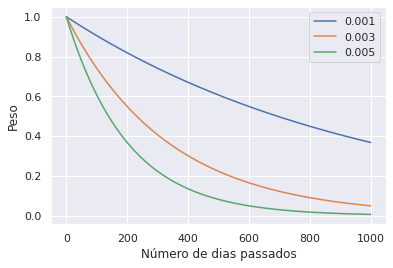

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
t = np.array(range(1000))
xis = [0.001, 0.003, 0.005]
for xi in xis:
    plt.plot(t, dc_decay(xi, t), label=str(xi))

plt.legend()
plt.xlabel("Número de dias passados")
plt.ylabel("Peso")

### **Optimization of the Time Factor**  

The greater the $\xi$ factor, the faster the decay over time. This raises the question: what is the optimal value for $\xi$?  

The general idea would be to optimize the attacking and defensive strength parameters of the model in the same way while varying the values of $\xi$ until we achieve the best model performance. We would still use the *log-likelihood* optimizer, but we need a different metric to analyze various $\xi$ values and determine the best one. The metric proposed by Dixon and Coles is the *Rank Probability Score*.  

> [Dixon & Coles Paper](http://constantinou.info/downloads/papers/solvingtheproblem.pdf)  

*Rank Probability Score* was proposed by Edward S. Epstein in 1969 as a method to compare probabilistic predictions against categorical data.  

> [Epstein's Paper](https://journals.ametsoc.org/view/journals/apme/8/6/1520-0450_1969_008_0985_assfpf_2_0_co_2.xml?tab_body=pdf)  

The main advantage is that, in addition to considering accuracy, it also accounts for the distance between the predicted and actual outcomes. This means we can measure the accuracy of win/draw/loss probabilities for each game and evaluate the overall error.  

**Note:**  
Due to the complexity of this task and the current scope of the project, we have decided not to proceed further with the development of this parameter.  

## **Conclusion**  

In this section, we modified the Poisson model to establish a dependency between match outcomes and the number of goals in cases such as `0-0`, `1-0`, and `0-1`, by introducing a new parameter, $\rho$. We also introduced and explained, but did not implement—due to its complexity—the possibility of incorporating a new temporal parameter, $t$, into the model. This parameter would influence the final prediction results as well as the attacking and defensive strength.  

While the overall model has improved, there are other methods to simulate, predict, and model football match results. In the next section, we will introduce another approach.  

# **Model III - Bayesian Hierarchical Model and PyMC3**

This section is based on the following paper:

*   *Bayesian Hierarchical Model for the Prediction of Football Results*
*   [https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)

In this section, we will use a Bayesian Hierarchical Model to predict football match results and compare the outcomes with the previous models.


## **Datasets and Model**  

The columns `home_team` and `away_team` contain the names of the teams, while `yg1` and `yg2` represent the number of goals scored by the home and away teams, respectively. We also retained the date column and the match result.  

In [ ]:
import pandas as pd

df1 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/P1.csv")
df2 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/P1.csv")
df3 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1920/P1.csv")

frames = [df1, df2, df3]

df = pd.concat(frames).rename(
    columns={"HomeTeam": "home_team",
             "AwayTeam": "away_team",
             "FTHG": "yg1",
             "FTAG": "yg2",
             "FTR": "result"})
df = df[["Date", "home_team", "away_team", "yg1", "yg2", "result"]]

df

,Date,home_team,away_team,yg1,yg2,result
0,06/08/2021,Sp Lisbon,Vizela,3,0,H
1,07/08/2021,Arouca,Estoril,0,2,A
2,07/08/2021,Moreirense,Benfica,1,2,A
3,07/08/2021,Maritimo,Sp Braga,0,2,A
4,08/08/2021,Guimaraes,Portimonense,0,1,A
...,...,...,...,...,...,...
301,25/07/2020,Benfica,Sp Lisbon,2,1,H
302,25/07/2020,Sp Braga,Porto,2,1,H
303,26/07/2020,Moreirense,Tondela,1,2,A
304,26/07/2020,Portimonense,Aves,2,0,H


Each team is assigned an `ID`, which will facilitate its identification in the future.

In [ ]:
import numpy as np

n_teams = len(df["home_team"].unique())

teams = (
    df[["home_team"]]
    .drop_duplicates()
    .sort_values("home_team")
    .reset_index(drop=True)
    .assign(team_index=np.arange(n_teams))
    .rename(columns={"home_team": "team"})
)

df = (
    df.merge(teams, left_on="home_team", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .merge(teams, left_on="away_team", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("Date")
)

df.head()

,Date,home_team,away_team,yg1,yg2,result,hg,ag
599,01/02/2020,Santa Clara,Pacos Ferreira,2,1,H,17,13
117,01/02/2020,Setubal,Porto,0,4,A,18,15
304,01/02/2020,Portimonense,Tondela,0,1,A,14,21
57,01/02/2021,Santa Clara,Belenenses,2,0,H,17,2
613,01/02/2021,Sp Lisbon,Benfica,1,0,H,20,3


The column `hg` contains the home team's `ID`, while the column `ag` contains the away team's `ID`. For example, Porto has `ID 15`, and Benfica has `ID 3`.  

Defining the training dataset and subsets:  

In [ ]:
train = df
goals_home_obs = train["yg1"].values
goals_away_obs = train["yg2"].values
home_team = train["hg"].values
away_team = train["ag"].values

The base model remains the same:  

> $goals\_home = home\_advantage + home\_attack + defence\_away$  

> $goals\_away = away\_attack + defence\_home$  

## **Bayesian Statistics**  

In our model, we will use Bayesian statistics. Therefore, in this case, we have a distribution of values for each model parameter, rather than a single value per parameter as we did in the previous models.  
The use of the Bayesian model leads us to employ a technique called Hierarchical Modeling. This technique allows us to account for the relationships between variables by considering them as a product of a common distribution.  
For us, this means we can avoid the issues of independence that the Poisson variables caused in the two previous models. In other words, there is no need to apply the Dixon and Coles adjustment.

## **PyMC3 Model**  

We will use the PyMC3 library in Python to build the model.  
The `home` parameter refers to the home advantage. This parameter is fixed because it is assumed that the advantage is constant across all teams and over time.  
The parameters `atts` and `defs` represent the attacking and defensive strength of each team.  
At the end of the code, we calculate `home_theta` and `away_theta`. We sum the *ratings* and the home advantage, then calculate the expected goal-scoring value for each team and apply the Poisson distribution.

In [ ]:
!pip install theano
!pip install pymc3

In [ ]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # home advantage
    home = pm.Flat("home")

    # attack ratings
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence ratings
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # apply sum zero constraints
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # calulate theta
    home_theta = tt.exp(home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(atts[away_team] + defs[home_team])

    # goal expectation
    home_points = pm.Poisson("home_goals", mu=home_theta, observed=goals_home_obs)
    away_points = pm.Poisson("away_goals", mu=away_theta, observed=goals_away_obs)

### **Model Fit**  

Now, let's fit the model by calling the **sample** function from PyMC3. Sampling is done 2000 times across `6` *chains*, resulting in a total of about `12000` *samples*. The *tune* variable is set to `1000`, meaning that each *chain* will discard `1000` *samples* before starting.

In [ ]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

### **Home Advantage IV**  

Let's see how the model behaves when adjusting the parameters. We'll start with the home advantage:

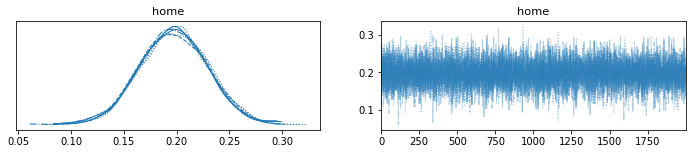

In [ ]:
with model:
    pm.plot_trace(trace, var_names=["home"]);

As mentioned earlier, with a Bayesian model, we have a distribution of possible parameters rather than a single one. Looking at the obtained graphs, we see that on the left, we get a relatively smooth curve centered around the value `0.195`, or `19.5%`, which is quite close to the values used earlier.

> Model I: `18.7%` | `17.1%`  

> Model II: `16.7%`  

> Model III: `19.5%`

### **Attacking Strength III**  

Now the same can be done for the attacking strength:

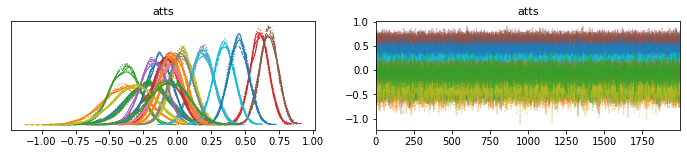

In [ ]:
with model:
    pm.plot_trace(trace, var_names=["atts"]);

Again, we have smooth curves, but the graph appears quite confusing due to the large number of curves. To address this, let's create a new plot, slightly different from the previous one.

<ipython-input-88-07e1c5661e8b>:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

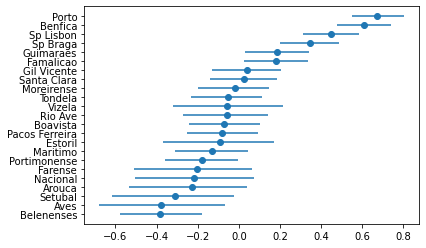

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

atts = (
    pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["atts"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=True)
)

plt.errorbar(
    atts["median"],
    atts["Team"],
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)

### **Defensive Strength III**  

Now the same can be done for the defensive strength:

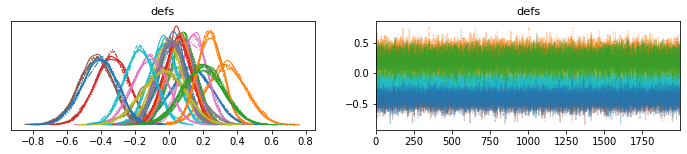

In [ ]:
with model:
    pm.plot_trace(trace, var_names=["defs"]);

Again, we have smooth curves, but the graph appears quite confusing due to the large number of curves. To address this, let's create a new plot, slightly different from the previous one.

<ipython-input-90-3f43e3574c7c>:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

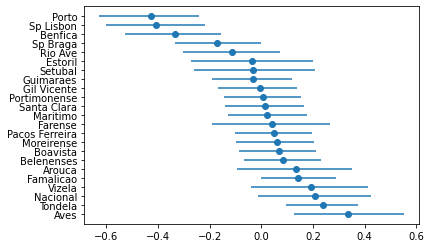

In [ ]:
defs = (
    pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["defs"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=False)
)

plt.errorbar(
    defs["median"],
    defs["Team"],
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)

The two blue bar charts show the average value (the point on each blue line) of the attacking and defensive strength of each team, along with their HDI (High Density Interval, the blue line). The HDI is at a `95%` confidence level.

The width of the HDI represents the uncertainty of the model for our parameter. Therefore, the wider the bar, the greater the uncertainty about the true value of the parameter. It is worth noting that the HDI is typically wider for teams that have recently been promoted to the top tier of Portuguese football, as we have less data available in our dataset.

### **Match Prediction III**  

As we know, this model is slightly different from the previous ones, as we don't have a specific value for each parameter. Instead, we have a distribution of values (around 12,000 values per parameter).  
To simplify, we calculated the average of each parameter, so that we can later use this average to calculate the expected number of goals.  
In the first lines of the code below, we see the instructions to calculate the average of the parameters. Then, as mentioned, we use the averages to calculate the expected number of goals.

In [ ]:
def goal_expectation(trace, home_team_id, away_team_id):   
    # obter os prâmetros
    home = np.mean(trace["home"])
    atts_home = np.mean([x[home_team_id] for x in trace["atts"]])
    atts_away = np.mean([x[away_team_id] for x in trace["atts"]])
    defs_home = np.mean([x[home_team_id] for x in trace["defs"]])
    defs_away = np.mean([x[away_team_id] for x in trace["defs"]])

    # calcular o theta
    home_theta = np.exp(home + atts_home + defs_away)
    away_theta = np.exp(atts_away + defs_home)

    # retorna a média por equipa
    return home_theta, away_theta

Now, it is only necessary to provide the model with the IDs to obtain the goal predictions. For example, Porto, ID 3, vs Benfica, ID 15.


In [ ]:
goal_expectation(trace, 3, 15)

(1.4522959552375645, 1.400016527232181)

Let's switch the order and determine the prediction if Benfica plays at home (the first ID provided is for the home team).


In [ ]:
goal_expectation(trace, 15, 3)

(1.7056456130625546, 1.192063769984597)

## **Conclusion**  

The Bayesian Hierarchical model still has some limitations, such as the lack of a temporal parameter $t$ that assigns weights to different matches based on their date. It also suffers from the effect of *Overshrinkage*, which is an issue associated with Hierarchical models, where extreme values are pulled toward the group mean.
What we mean by this is that the stronger teams don't appear as strong as they should, and similarly, the weaker teams don't appear as weak as they should. In other words, our measures are influenced and drawn toward the average, which affects the performance of this model.
The solution proposed by Baio and Blangiardo is to restructure our model to create three groups: *`Top Teams`*, *`Mid-Table Teams`*, and *`Bottom Teams`*. The model then uses these groups within the Hierarchical framework so that the parameters are estimated through a distribution of similar teams, reducing *Overshrinkage*.
To conclude, this model is capable of predicting attacking strength, defensive strength, home advantage, and match results. It is quite similar to the other models, even though it is simpler, as it doesn't have the temporal parameter $t$ and doesn't require the $\rho$ parameter.
